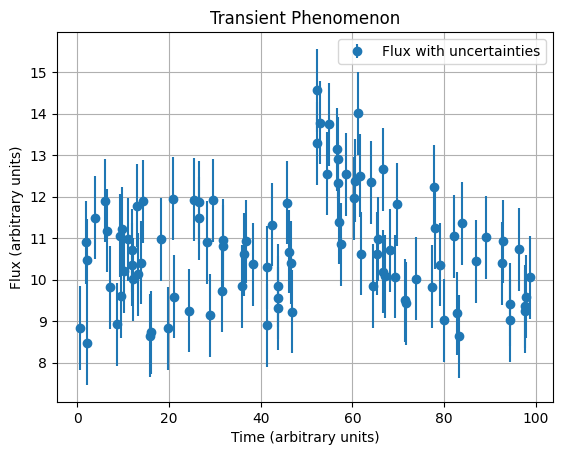

In [53]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Latex, display
# Load the data
data = np.load('/Users/albertozanelli/Desktop/astrostatistics_bicocca_2025/solutions/transient.npy')

# Extract columns
time = data[:, 0]
flux = data[:, 1]
uncertainties = data[:, 2]

# Plot the data with uncertainties
plt.errorbar(time, flux, yerr=uncertainties, fmt='o', label='Flux with uncertainties')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Transient Phenomenon')
plt.legend()
plt.grid()
plt.show()

In [54]:
import emcee
import tqdm

def burst_model(t, b, A, alpha, t_0):
    y = np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))
    return y

def Prior(params):
    b, A, alpha, t_0 = params
    if 0 < b < 20 and 0 < A < 20 and 0 < alpha < np.exp(5) and 0 < t_0 < 100:
        return 1  # Uniform prior
    return 0  # Log(0) for invalid parameters

# Adjust the Likelihood function to avoid overflow issues
def logLikelihood(params, t, y, yerr):
    b, A, alpha, t_0 = params
    dati_dal_modello = burst_model(t, b, A, alpha, t_0)
    diff = dati_dal_modello - y
    return np.sum(-0.5 * (diff / yerr) ** 2)

# Adjust the Posterior and LogPosterior functions accordingly
def myPosterior(params, t, y, yerr):
    prior = Prior(params)
    if prior == 0:
        return 0
    return np.exp(logLikelihood(params, t, y, yerr)) * prior

def myLogPosterior(params, t, y, yerr):
    prior = Prior(params)
    if prior == 0:
        return -np.inf
    return logLikelihood(params, t, y, yerr) + np.log(prior)

In [55]:
# Define the number of dimensions, walkers, and steps
# Adjust the Prior function to avoid invalid values

ndim = 4  # Number of parameters in the model
nwalkers = 30  # Number of MCMC walkers
nsteps = 70000  # Number of MCMC steps for each walker
burn = 5000  # Number of burn-in steps

# Initialize the walkers' starting positions
np.random.seed(42)  # For reproducibility
initial_guess = [10, 10, 1, 50]  # Initial guess for the parameters
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
# Modify the proposal width by scaling the initial positions
proposal_scale = 1e-3  # Adjust the scale to modify the proposal width
pos = initial_guess + proposal_scale * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=(time, flux, uncertainties))

# Run the MCMC sampler
print("Running MCMC...")
sampler.run_mcmc(pos, nsteps)
print("MCMC complete.")

# Calculate the autocorrelation time for thinning
tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.mean(tau) + 1)

# Extract the samples
trace = sampler.get_chain(discard=burn, thin=thin, flat=True)  # Discard burn-in and thin the chain

print(f"Shape of the trace: {trace.shape}") # a vector for each parameter
print(f"Autocorrelation time: {tau}")
print(f"Thinning factor: {thin}")




Running MCMC...
MCMC complete.
[60.53444856 80.01444649 82.63133837 83.11426207]
Shape of the trace: (25320, 4)
Autocorrelation time: [60.53444856 80.01444649 82.63133837 83.11426207]
Thinning factor: 77


Text(0.5, 0, 'step number')

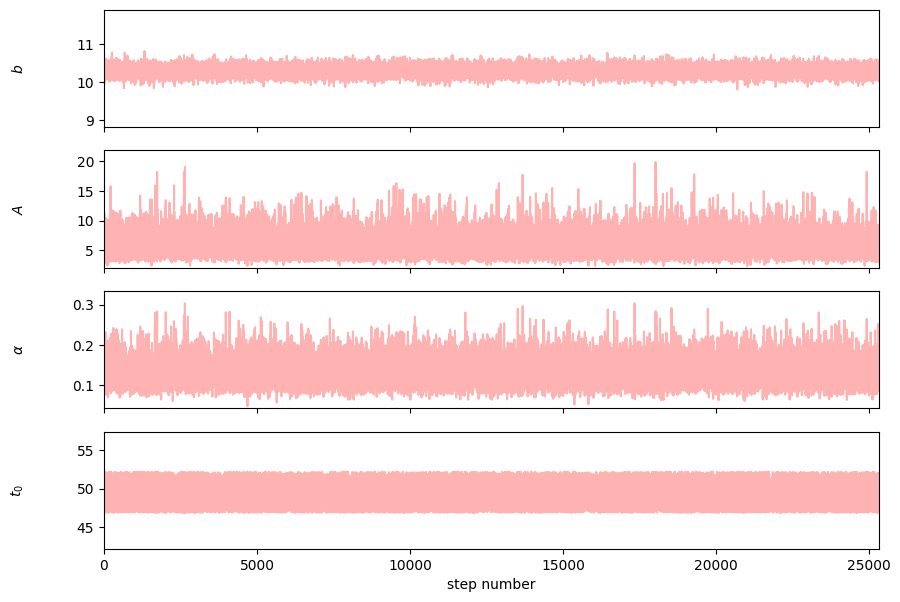

In [56]:
from IPython.display import Latex, display
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r"$b$", r"$A$", r"$\alpha$", r"$t_0$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(trace[:, i], "r", alpha=0.3)
    ax.set_xlim(0, len(trace))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim(np.min(trace[:, i])-0.1*np.min(trace[:, i]), np.max(trace[:, i])+0.1*np.max(trace[:, i]))

axes[-1].set_xlabel("step number")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

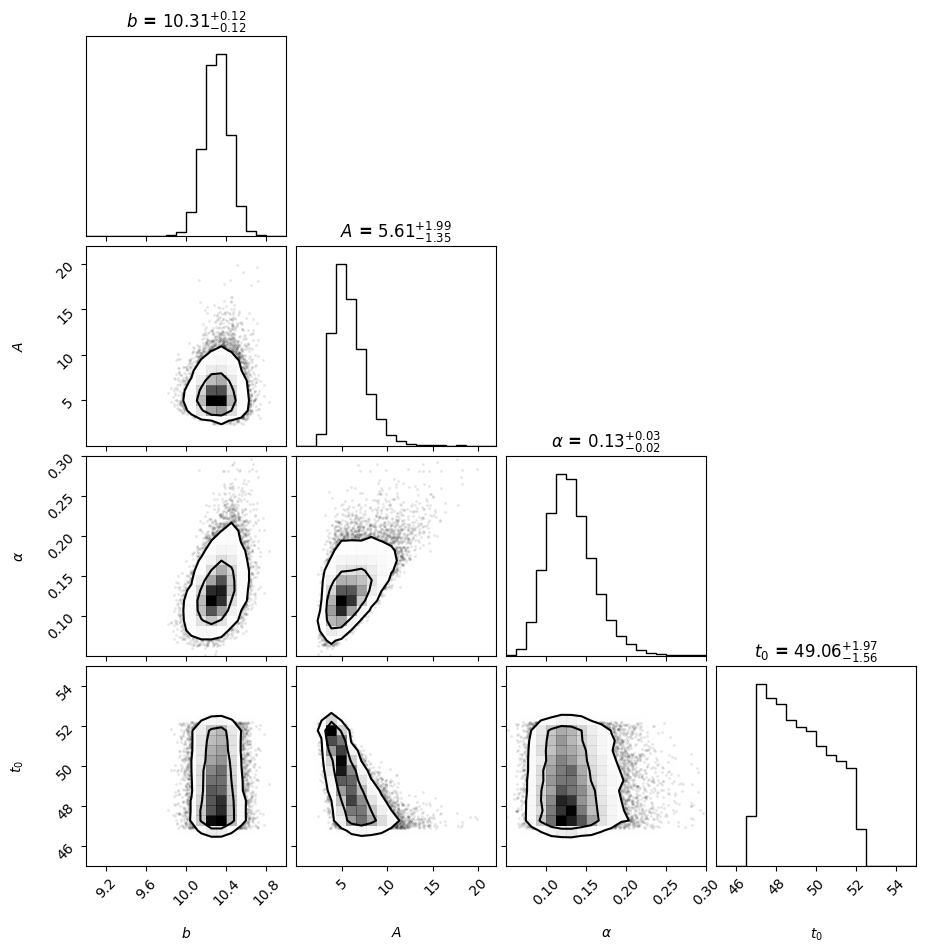

In [57]:
import corner
from IPython.display import display, Latex

# Calculate the median and 90% credible region for each parameter
# Correct the LaTeX string formatting to avoid errors
percentiles = [5, 50, 95]  # 90% credible region corresponds to 5th and 95th percentiles
results = {}

for i in range(len(labels)):
    lower, median, upper = np.percentile(trace[:, i], percentiles)
    error_up = upper - median
    error_down = lower - median
    results[i] = (median, error_down, error_up)
    
# Extract the first element (median) from each entry in the results dictionary
median_vector = [results[i][0] for i in range(len(labels))]
error_down_vector = [results[i][1] for i in range(len(labels))]
error_up_vector = [results[i][2] for i in range(len(labels))]


# Ora stampiamo tutto in LaTeX
for label, median, err_down, err_up in zip(labels, median_vector, error_down_vector, error_up_vector):
    latex_str = (
        fr"{label} = ${median:.2f}^{{+{err_up:.2f}}}_{{{err_down:.2f}}}$"
    )
    display(Latex(latex_str))

# Create the corner plot
fig = corner.corner(
    trace, 
    labels=labels,
    levels=[0.68, 0.95], 
    show_titles=True, 
    title_fmt=".2f", 
    title_kwargs={"fontsize": 12, "color": "black", "fontweight": "bold"},  # Customize title appearance
    plot_contours=True, 
    range=[(9, 11), (0, 22), (0.05, 0.3), (45, 55)]  # Define manual limits for each parameter
)



# Display the plot
plt.show()

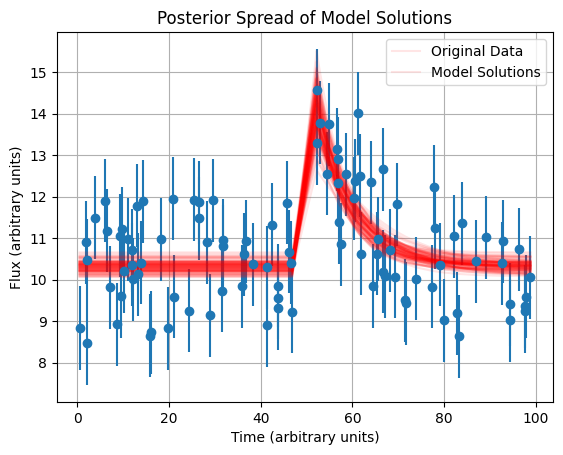

In [58]:
# Number of samples to plot
num_samples = 100

# Randomly select samples from the burned and thinned chain
np.random.seed(42)  # For reproducibility
selected_samples = trace[np.random.choice(trace.shape[0], num_samples, replace=False)]

# Plot the original data
plt.errorbar(time, flux, yerr=uncertainties, fmt='o', label='Original Data')

# Plot the burst time-series for the selected samples
for sample in selected_samples:
    model = burst_model(time, *sample)
    plt.plot(time, model, color='red', alpha=0.1)

# Add labels and title
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Posterior Spread of Model Solutions')
plt.legend(['Original Data', 'Model Solutions'])
plt.grid()
plt.show()

In [80]:
from scipy.stats import uniform
import dynesty
import dynesty.plotting as dyplot
from dynesty import utils as dyfunc

def burst_model(t, params):
    b, A, alpha, t_0 = params
    """y = np.full_like(t, b)
    mask = t >= t_0
    y[mask] += A * np.exp(-alpha * (t[mask] - t_0))"""
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))


def Prior_burst_dynesty(params):
    b, A, alpha, t_0 = params
    # Transform uniform [0, 1] inputs to the desired parameter ranges
    b = uniform.ppf(b, loc=0, scale=50)  # b in [0, 20]
    A = uniform.ppf(A, loc=0.01, scale=50)  # A in [0, 20]
    alpha = uniform.ppf(alpha, loc=np.exp(-5), scale=np.exp(5))  # alpha in [0, exp(5)]
    t_0 = uniform.ppf(t_0, loc=0, scale=100)  # t_0 in [0, 100]
    
    p = b, A, alpha, t_0
    return p

def logLikelihood_burst(params, t, y, yerr):
    dati_dal_modello = burst_model(t, params)
    diff = dati_dal_modello - y
    return np.sum(-0.5 * (diff / yerr) ** 2)


sampler = dynesty.NestedSampler(
    logLikelihood_burst, Prior_burst_dynesty, ndim,
    logl_args=(time, flux, uncertainties),
    nlive=300,          # più live points = più preciso 
    #bootstrap=0         # niente bootstrap = niente warning
)
sampler.run_nested()  # criterio di stop più sensato
sresults = sampler.results

/var/folders/57/gp84p4410yx1sr6bqvtc5qs00000gn/T/ipykernel_7050/2878281935.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
/var/folders/57/gp84p4410yx1sr6bqvtc5qs00000gn/T/ipykernel_7050/2878281935.py:11: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1089it [00:03, 124.03it/s, bound: 0 | nc: 75 | ncall: 10851 | eff(%): 10.036 | loglstar:   -inf < -110.713 <    inf | logz: -118.461 +/-  0.150 | dlogz: 27.962 >  0.309]    /var/folders/57/gp84p4410yx1sr6bqvtc5qs00000gn/T/ipykernel_7050/2878281935.py:11: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1102it [00:03, 124.07it/s, bound: 1 | nc: 3 | ncall: 10996 | eff(%): 10.022 | loglstar:   -inf < -108.979 <    inf | logz: -116.514 +/-  0.147 | dlogz: 25.906 >  0.309] /var/folders/57/gp84p4410yx1sr6bqvtc5qs00000gn/T/ipykernel_7050/2878281935.py:11: RuntimeWarning: overflow encoun

Bayesian evidence -67.99270847995457


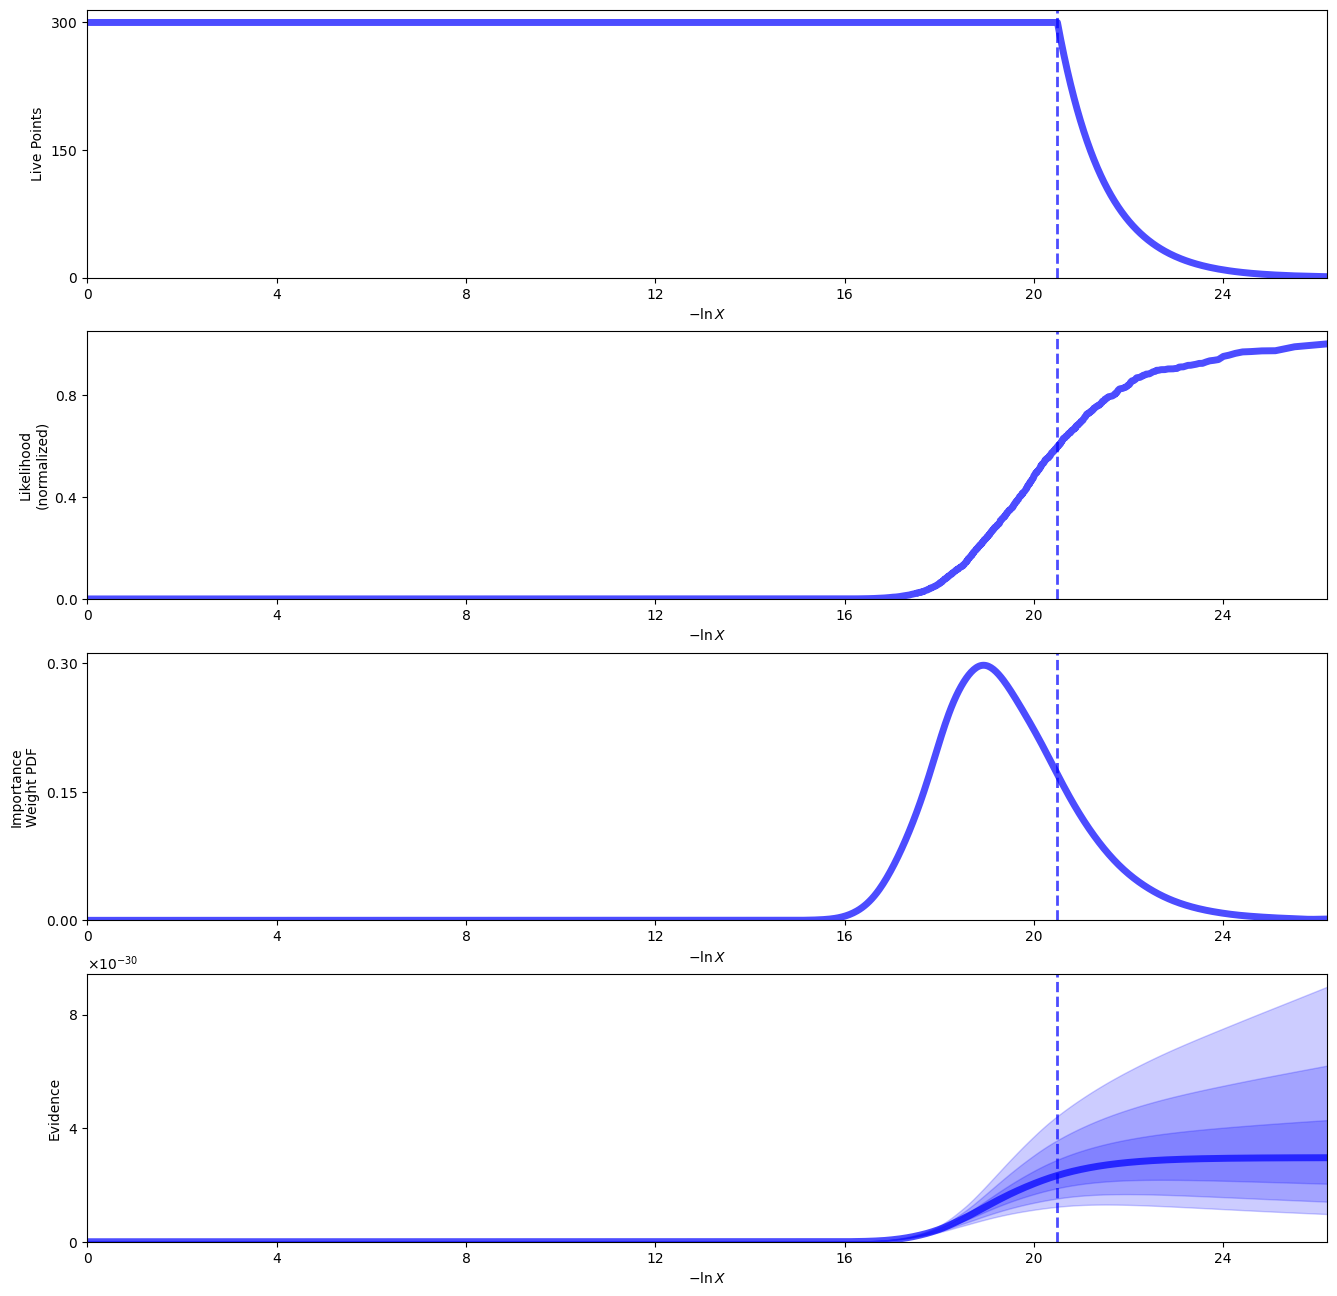

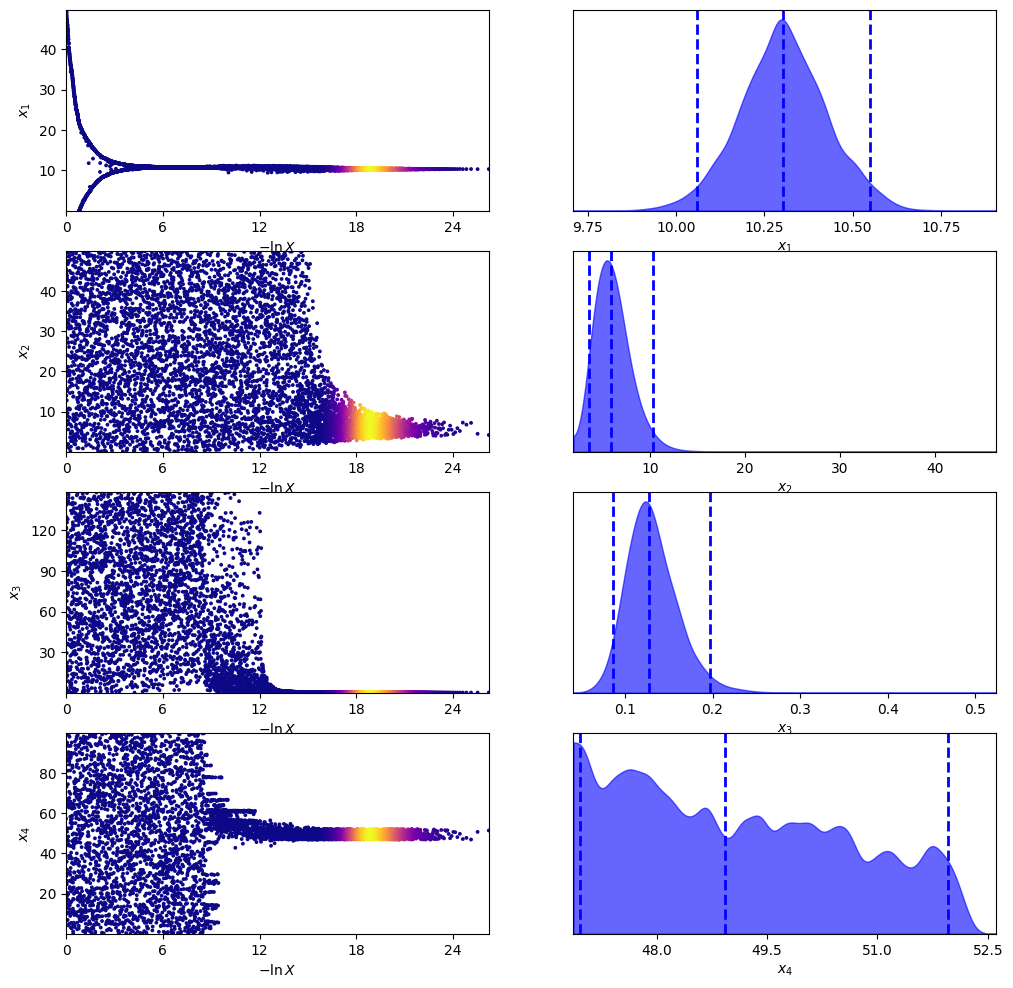

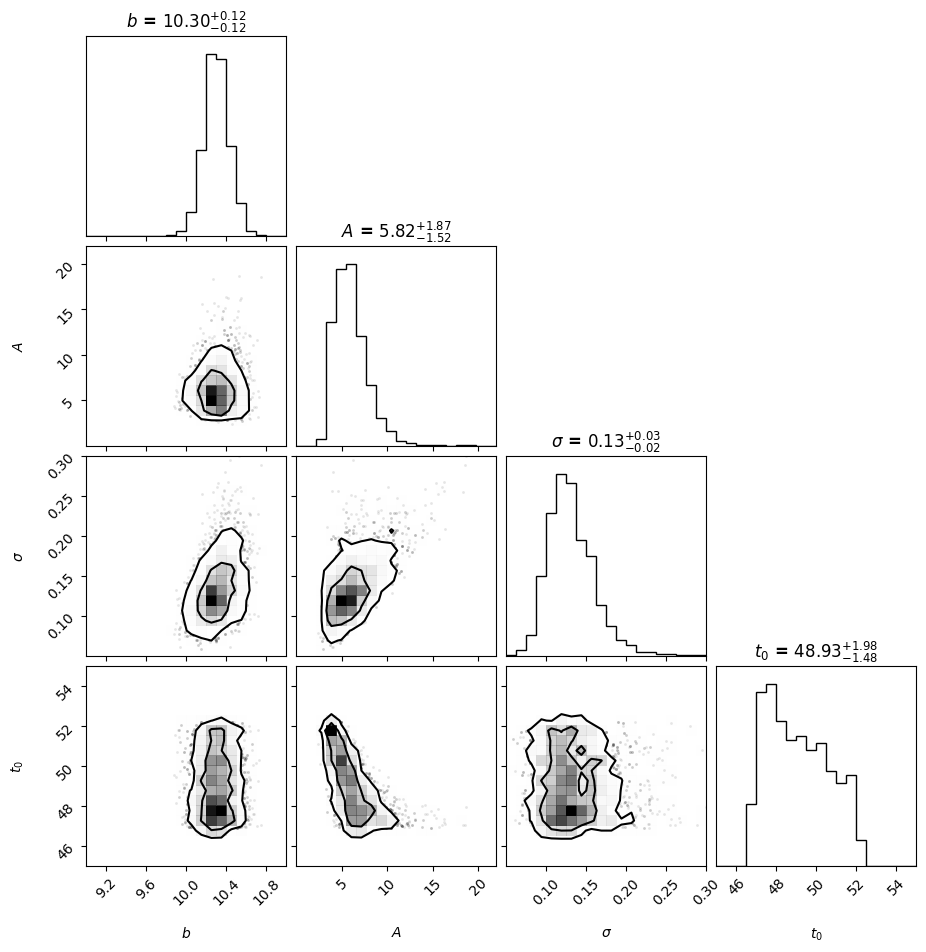

In [79]:
from dynesty import plotting as dyplot
import corner


# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)

samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", evidence)

samples_equal = dyfunc.resample_equal(samples, weights)


fig = corner.corner(
    samples_equal, 
    labels=labels, 
    levels=[0.68, 0.95], 
    show_titles=True, 
    title_fmt=".2f", 
    title_kwargs={"fontsize": 12, "color": "black", "fontweight": "bold"},  # Customize title appearance
    plot_contours=True, 
    range=[(9, 11), (0, 22), (0.05, 0.3), (45, 55)]  # Define manual limits for each parameter
)

plt.show()

Best fit: [10.20461269  7.25868937  0.1131544  47.590453  ]


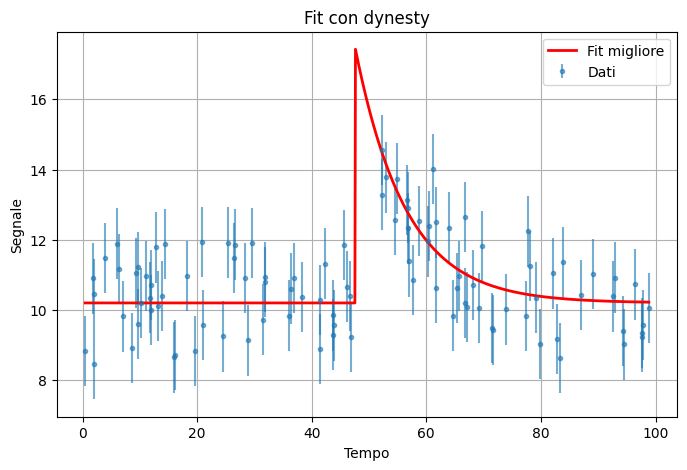

In [77]:
import matplotlib.pyplot as plt

# 1. Ricostruisci il modello usando il best fit
i_best = np.argmax(sresults.logl)
best_fit_params = samples_equal[i_best]

print("Best fit:", best_fit_params)

b_fit, A_fit, alpha_fit, t0_fit = best_fit_params

time_fine = np.linspace(time.min(), time.max(), 1000)
model_fit_fine = burst_model(time_fine, b_fit, A_fit, alpha_fit, t0_fit)



# 2. Plot dei dati e del modello
plt.figure(figsize=(8, 5))
plt.errorbar(time, flux, yerr=uncertainties, fmt='.', label='Dati', alpha=0.6)
plt.plot(time_fine, model_fit_fine, color='red', lw=2, label='Fit migliore')
plt.xlabel('Tempo')
plt.ylabel('Segnale')
plt.legend()
plt.title('Fit con dynesty')
plt.grid()
plt.show()


In [66]:
def gaussian_model_1(t, b, A, sigma, t_0):
    y = np.full_like(t, b)
    mask = t >= t_0
    y[mask] += A * np.exp(-0.5 * ((t[mask] - t_0) / (sigma)) ** 2)
    return y

def gaussian_model_2(t, b, A, sigma, t_0):
    y = np.full_like(t, b)
    y += A * np.exp(-0.5 * ((t - t_0) / (sigma)) ** 2)
    return y


def Prior_gaussian(params):
    b, A, sigma, t_0 = params
    # Transform uniform [0, 1] inputs to the desired parameter ranges
    b = uniform.ppf(b, loc=0, scale=20)  # b in [0, 20]
    A = uniform.ppf(A, loc=0.01, scale=20)  # A in [0, 20]
    sigma = uniform.ppf(sigma, loc=np.exp(-2), scale=np.exp(2))  # sigma in [0.1, exp(5)]
    t_0 = uniform.ppf(t_0, loc=0, scale=100)  # t_0 in [0, 100]
    return b, A, sigma, t_0

def logLikelihood_gaussian(params, t, y, yerr):
    b, A, sigma, t_0 = params
    dati_dal_modello = gaussian_model_2(t, b, A, sigma, t_0)
    diff = dati_dal_modello - y
    return np.sum(-0.5 * (diff / yerr) ** 2)


sampler_gaussian = dynesty.NestedSampler(
    logLikelihood_gaussian, Prior_gaussian, ndim,
    logl_args=(time, flux, uncertainties),
    #nlive=1000, # più live points = più preciso
    bootstrap=0  # niente bootstrap = niente warning
)
sampler_gaussian.run_nested()  # criterio di stop più sensato
sresults_gaussian = sampler_gaussian.results

6586it [00:12, 548.45it/s, +500 | bound: 24 | nc: 1 | ncall: 35832 | eff(%): 20.055 | loglstar:   -inf < -52.462 <    inf | logz: -64.886 +/-  0.156 | dlogz:  0.001 >  0.509]


Bayesian evidence -64.88576555940784


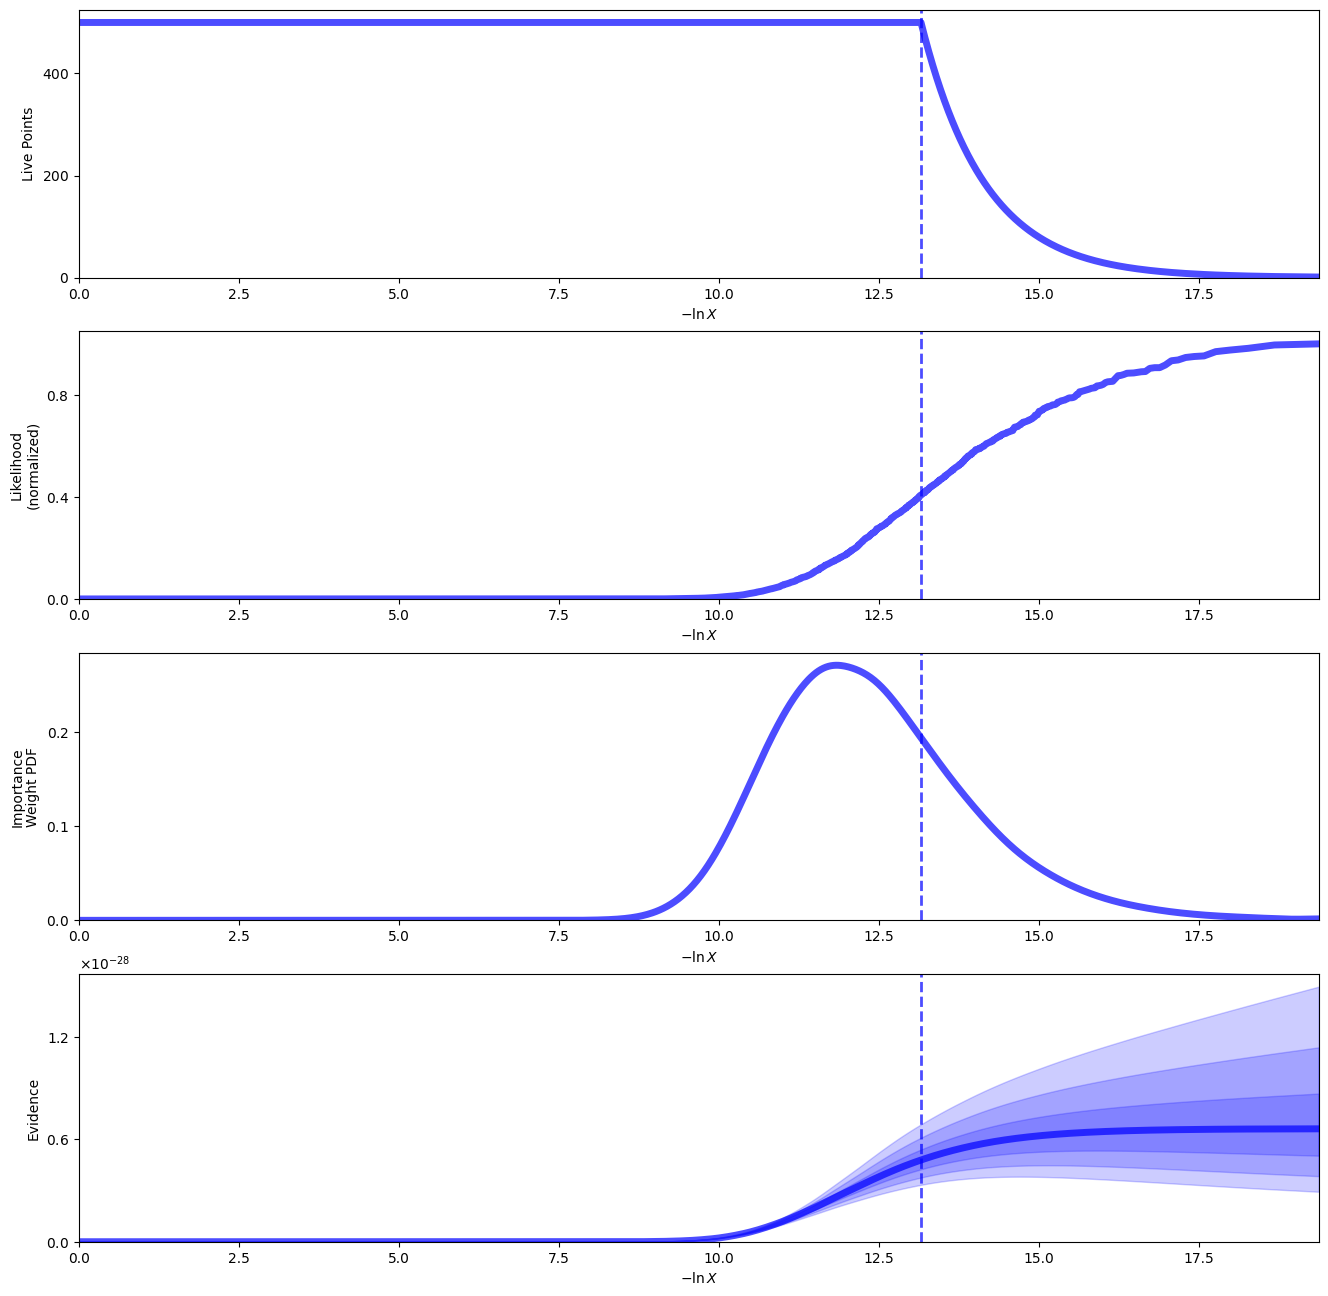

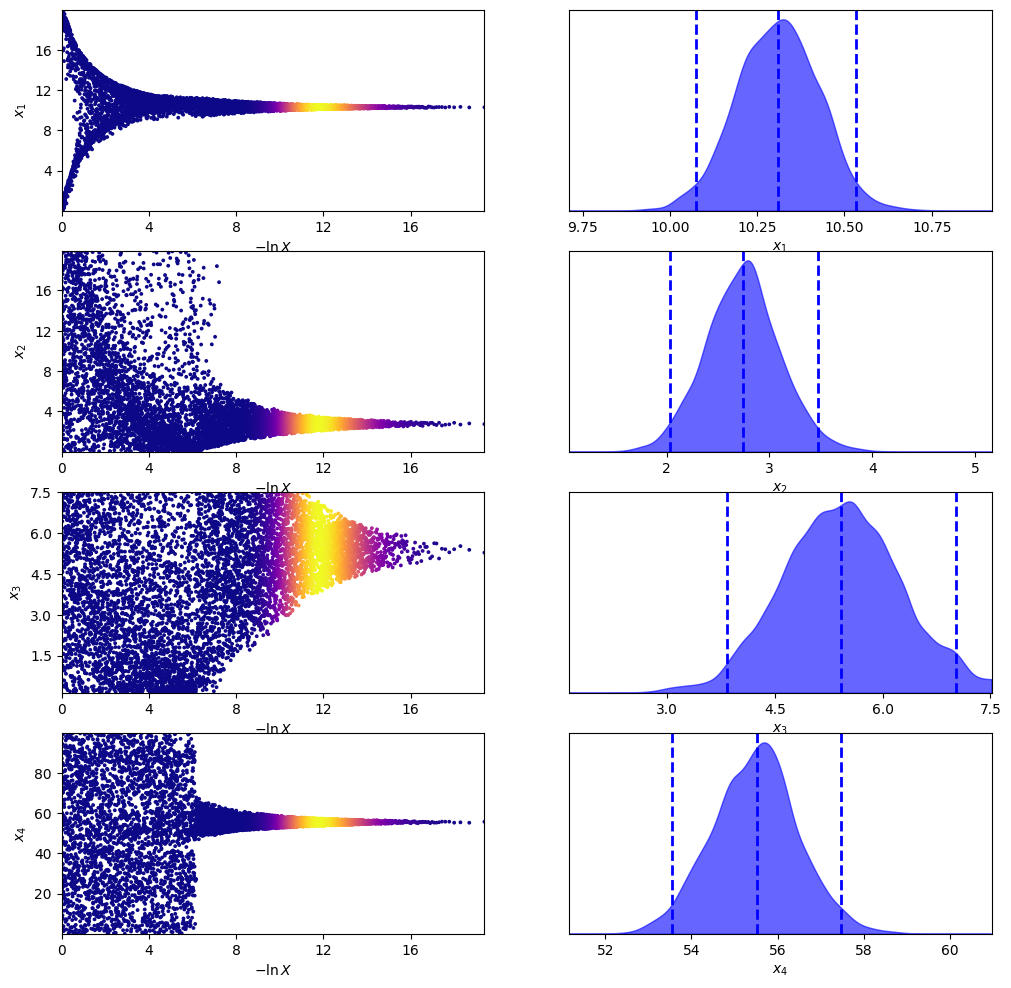

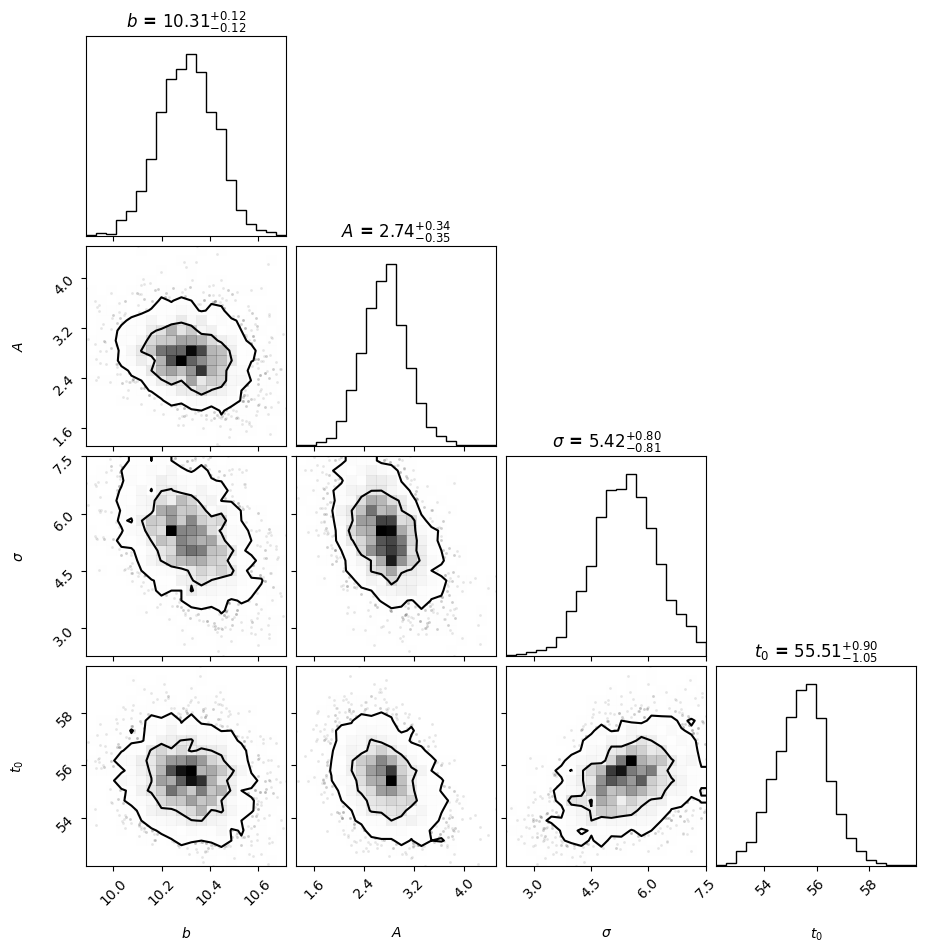

In [71]:
from dynesty import plotting as dyplot
import corner


# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults_gaussian)
tfig, taxes = dyplot.traceplot(sresults_gaussian)

samples_gaussian = sresults_gaussian.samples  # samples
weights_gaussian = np.exp(sresults_gaussian.logwt - sresults_gaussian.logz[-1])  # normalized weights
evidence_gaussian = sresults_gaussian.logz[-1] #evidence

print("Bayesian evidence", evidence_gaussian)

samples_equal_gaussian = dyfunc.resample_equal(samples_gaussian, weights_gaussian)

labels = [r"$b$", r"$A$", r"$\sigma$", r"$t_0$"]

fig = corner.corner(
    samples_equal_gaussian, 
    labels=labels, 
    levels=[0.68, 0.95], 
    show_titles=True, 
    title_fmt=".2f", 
    title_kwargs={"fontsize": 12, "color": "black", "fontweight": "bold"},  # Customize title appearance
    plot_contours=True, 
    #range=[(9, 11), (0, 22), (0.0, 20), (45, 55)]  # Define manual limits for each parameter
)

plt.show()

Best fit: [10.39837763  2.28103371  6.27552553 54.90087651]


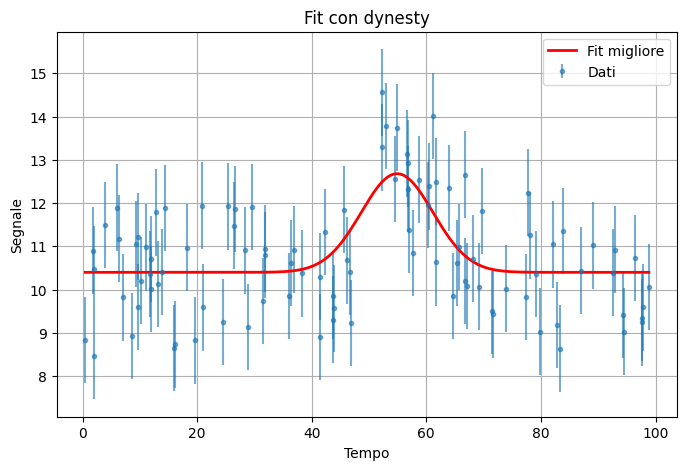

In [68]:
import matplotlib.pyplot as plt

# 1. Ricostruisci il modello usando il best fit
i_best = np.argmax(sresults_gaussian.logl)
best_fit_params = samples_equal_gaussian[i_best]

print("Best fit:", best_fit_params)

b_fit, A_fit, sigma_fit, t0_fit = best_fit_params

time_fine = np.linspace(time.min(), time.max(), 1000)
model_fit_fine = gaussian_model_2(time_fine, b_fit, A_fit, sigma_fit, t0_fit)



# 2. Plot dei dati e del modello
plt.figure(figsize=(8, 5))
plt.errorbar(time, flux, yerr=uncertainties, fmt='.', label='Dati', alpha=0.6)
plt.plot(time_fine, model_fit_fine, color='red', lw=2, label='Fit migliore')
plt.xlabel('Tempo')
plt.ylabel('Segnale')
plt.legend()
plt.title('Fit con dynesty')
plt.grid()
plt.show()


In [81]:
print("Bayesian evidence for Burst model:", np.exp(evidence))
print("Bayesian evidence for Gaussian model:", np.exp(evidence_gaussian))

# Compare the Bayesian evidence for both models
print("Bayes Factor (Gaussian / Burst):", np.exp(evidence_gaussian) / np.exp(evidence))
bayes_factor = np.exp(evidence_gaussian) / np.exp(evidence)

if bayes_factor < 1:
    jeffreys_scale = "Negative evidence for Gaussian model"
elif 1 <= bayes_factor < 3:
    jeffreys_scale = "Barely worth mentioning"
elif 3 <= bayes_factor < 10:
    jeffreys_scale = "Substantial evidence for Gaussian model"
elif 10 <= bayes_factor < 30:
    jeffreys_scale = "Strong evidence for Gaussian model"
elif 30 <= bayes_factor < 100:
    jeffreys_scale = "Very strong evidence for Gaussian model"
else:
    jeffreys_scale = "Decisive evidence for Gaussian model"

print("Jeffreys' scale for Bayes Factor (Gaussian / Burst):", jeffreys_scale)


Bayesian evidence for Burst model: 2.9589790990255964e-30
Bayesian evidence for Gaussian model: 6.614089440799994e-29
Bayes Factor (Gaussian / Burst): 22.352606150472774
Jeffreys' scale for Bayes Factor (Gaussian / Burst): Strong evidence for Gaussian model
